In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from scipy.stats import ks_2samp


Phase 1 – Baseline Model Training

In [3]:
# Generate synthetic baseline dataset
X, y = make_classification(
    n_samples=5000,
    n_features=10,
    n_informative=6,
    n_redundant=2,
    weights=[0.5, 0.5],
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


baseline_pred = model.predict(X_test)
baseline_proba = model.predict_proba(X_test)[:, 1]

print("Baseline Performance")
print("Accuracy:", accuracy_score(y_test, baseline_pred))
print("F1 Score:", f1_score(y_test, baseline_pred))
print("AUC:", roc_auc_score(y_test, baseline_proba))


Baseline Performance
Accuracy: 0.9126666666666666
F1 Score: 0.9117845117845118
AUC: 0.9750701928770455


Phase 2 – Drift Simulation Functions

In [5]:
#Covariate Drift (Feature Shift)
def covariate_drift(X, step):
    X_drifted = X.copy()
    drift_strength = step * 0.2
    X_drifted[:, 0] += drift_strength 
    return X_drifted


In [6]:
#Prior Probability Drift (Target Shift)
def prior_drift(y, step):
    new_positive_ratio = min(0.9, 0.5 + step * 0.04)
    y_drifted = np.random.binomial(1, new_positive_ratio, size=len(y))
    return y_drifted


In [7]:
#Concept Drift (Decision Boundary Change)
def concept_drift(y, step):
    y_drifted = y.copy()
    flip_prob = step * 0.03
    mask = np.random.rand(len(y)) < flip_prob
    y_drifted[mask] = 1 - y_drifted[mask]
    return y_drifted



Phase 3 – Performance Degradation Tracking

In [8]:
results = []

for step in range(1, 11):

    # Apply drift
    X_drift = covariate_drift(X_test, step)
    y_drift = concept_drift(y_test, step)

    # Predictions
    pred = model.predict(X_drift)
    proba = model.predict_proba(X_drift)[:, 1]

    # Metrics
    acc = accuracy_score(y_drift, pred)
    f1 = f1_score(y_drift, pred)
    auc = roc_auc_score(y_drift, proba)

    results.append([step, acc, f1, auc])

df_results = pd.DataFrame(results, columns=["Step", "Accuracy", "F1", "AUC"])
df_results


,Step,Accuracy,F1,AUC
0,1,0.887333,0.886348,0.943707
1,2,0.858667,0.858289,0.915950
2,3,0.835333,0.832995,0.885634
3,4,0.806667,0.804318,0.848204
4,5,0.772000,0.769542,0.815613
5,6,0.760000,0.752407,0.799837
6,7,0.718000,0.706861,0.763057
7,8,0.728667,0.721424,0.780277
8,9,0.676667,0.660602,0.702156
9,10,0.648000,0.631285,0.687391


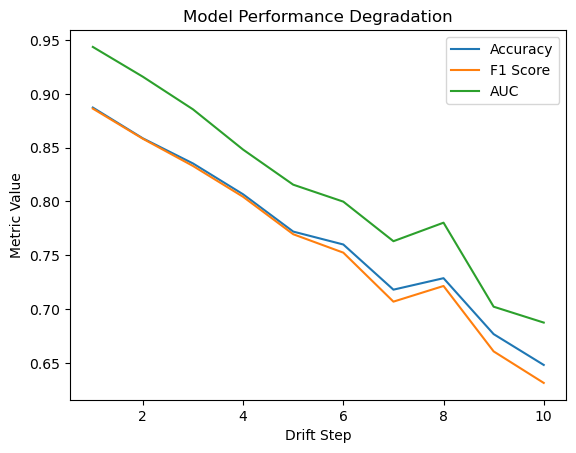

In [9]:
plt.figure()
plt.plot(df_results.Step, df_results.Accuracy, label="Accuracy")
plt.plot(df_results.Step, df_results.F1, label="F1 Score")
plt.plot(df_results.Step, df_results.AUC, label="AUC")

plt.xlabel("Drift Step")
plt.ylabel("Metric Value")
plt.title("Model Performance Degradation")
plt.legend()
plt.show()


Phase 4 – Drift Detection Metrics

In [10]:
def calculate_psi(expected, actual, bins=10):

    def scale_range(data, min_val, max_val):
        return (data - min_val) / (max_val - min_val + 1e-6)

    expected_scaled = scale_range(expected, expected.min(), expected.max())
    actual_scaled = scale_range(actual, expected.min(), expected.max())

    breakpoints = np.linspace(0, 1, bins + 1)

    expected_counts = np.histogram(expected_scaled, breakpoints)[0]
    actual_counts = np.histogram(actual_scaled, breakpoints)[0]

    expected_perc = expected_counts / len(expected)
    actual_perc = actual_counts / len(actual)

    psi = np.sum((actual_perc - expected_perc) * np.log((actual_perc + 1e-6) / (expected_perc + 1e-6)))

    return psi


In [11]:
#KS Test
def ks_drift_test(expected, actual):
    stat, p_value = ks_2samp(expected, actual)
    return stat, p_value



In [12]:
#Apply Drift Detection
psi_values = []
ks_pvalues = []

baseline_feature = X_test[:, 0]

for step in range(1, 11):

    X_drift = covariate_drift(X_test, step)
    drifted_feature = X_drift[:, 0]

    psi_val = calculate_psi(baseline_feature, drifted_feature)
    _, ks_p = ks_drift_test(baseline_feature, drifted_feature)

    psi_values.append(psi_val)
    ks_pvalues.append(ks_p)

df_results["PSI"] = psi_values
df_results["KS_pvalue"] = ks_pvalues

df_results


,Step,Accuracy,F1,AUC,PSI,KS_pvalue
0,1,0.887333,0.886348,0.943707,0.006306,1.962658e-01
1,2,0.858667,0.858289,0.915950,0.022092,1.112368e-03
2,3,0.835333,0.832995,0.885634,0.055406,4.903208e-07
3,4,0.806667,0.804318,0.848204,0.097159,1.837147e-11
4,5,0.772000,0.769542,0.815613,0.143774,9.453208e-17
5,6,0.760000,0.752407,0.799837,0.212934,1.401849e-23
6,7,0.718000,0.706861,0.763057,0.293796,4.188381e-30
7,8,0.728667,0.721424,0.780277,0.392370,6.049392e-39
8,9,0.676667,0.660602,0.702156,0.509962,9.820506e-49
9,10,0.648000,0.631285,0.687391,0.640021,3.235620e-60


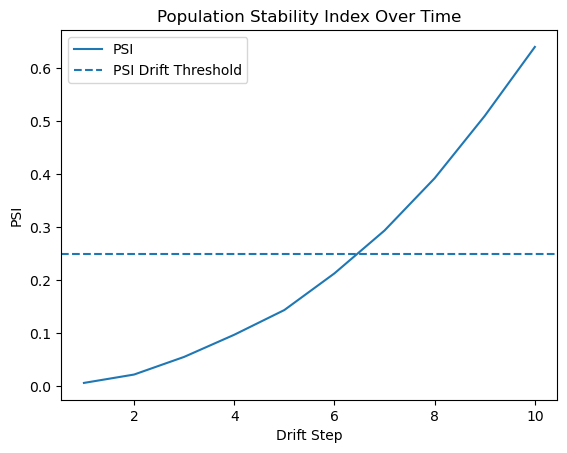

In [13]:
plt.figure()
plt.plot(df_results.Step, df_results.PSI, label="PSI")
plt.axhline(0.25, linestyle='--', label="PSI Drift Threshold")

plt.xlabel("Drift Step")
plt.ylabel("PSI")
plt.title("Population Stability Index Over Time")
plt.legend()
plt.show()


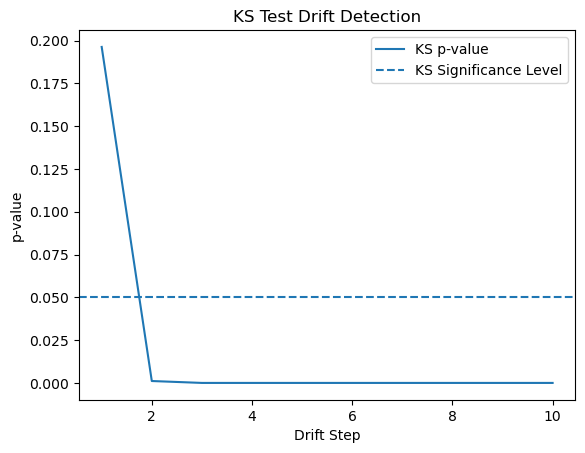

In [14]:
plt.figure()
plt.plot(df_results.Step, df_results.KS_pvalue, label="KS p-value")
plt.axhline(0.05, linestyle='--', label="KS Significance Level")

plt.xlabel("Drift Step")
plt.ylabel("p-value")
plt.title("KS Test Drift Detection")
plt.legend()
plt.show()


Phase 5 – Failure Threshold Definition

In [16]:
FAILURE_ACCURACY = 0.75
FAILURE_F1 = 0.70
FAILURE_AUC = 0.80

failure_points = df_results[
    (df_results.Accuracy < FAILURE_ACCURACY) |
    (df_results.F1 < FAILURE_F1) |
    (df_results.AUC < FAILURE_AUC)
]

print(" Model becomes unreliable at:")
failure_points.head(1)


 Model becomes unreliable at:


,Step,Accuracy,F1,AUC,PSI,KS_pvalue
5,6,0.76,0.752407,0.799837,0.212934,1.401849e-23


Phase 6 – Retraining Policy Logic

In [18]:
for i, row in df_results.iterrows():

    if row["PSI"] > 0.25:
        print(f"Retraining Triggered at Step {row['Step']} (PSI={row['PSI']:.3f})")
        break


Retraining Triggered at Step 7.0 (PSI=0.294)
